### Importing libraries

In [1]:
import datetime
import warnings
import time
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')


In [2]:
# Applicable sklearn libraries
from sklearn.metrics import accuracy_score, classification_report,plot_confusion_matrix,mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split ,KFold,RandomizedSearchCV,GridSearchCV,cross_val_score

#import preprocessing module

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


# XGBoost 
from xgboost import XGBRegressor

# CatBoost
from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor
from sklearn.ensemble import BaggingRegressor

###  Load the dataset

In [3]:
# Load files into a pandas dataframe
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

###  Data Assessing and Cleaning

In [4]:
# Let’s observe the shape of our datasets.
print('train data shape :', train.shape)
print('test data shape :', test.shape)

train data shape : (107833, 10)
test data shape : (9333, 9)


In [5]:
# inspect train data
train.head()

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0


In [6]:
# inspect train data
test.head()

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC
0,test_id_0,2016-05-04,TU 0700,DJE,TUN,2016-05-04 06:40:00,2016-05-04 07.30.00,ATA,TU 32AIMF
1,test_id_1,2016-05-05,TU 0395,TUN,BKO,2016-05-05 15:20:00,2016-05-05 20.05.00,ATA,TU 320IMW
2,test_id_2,2016-05-06,TU 0745,FRA,TUN,2016-05-06 10:00:00,2016-05-06 12.25.00,ATA,TU 32AIMC
3,test_id_3,2016-05-11,TU 0848,BEY,TUN,2016-05-11 09:40:00,2016-05-11 13.10.00,ATA,TU 31BIMO
4,test_id_4,2016-05-11,TU 0635,ORY,MIR,2016-05-11 09:50:00,2016-05-11 12.35.00,ATA,TU 736IOQ


In [7]:
# inspect data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      107833 non-null  object 
 1   DATOP   107833 non-null  object 
 2   FLTID   107833 non-null  object 
 3   DEPSTN  107833 non-null  object 
 4   ARRSTN  107833 non-null  object 
 5   STD     107833 non-null  object 
 6   STA     107833 non-null  object 
 7   STATUS  107833 non-null  object 
 8   AC      107833 non-null  object 
 9   target  107833 non-null  float64
dtypes: float64(1), object(9)
memory usage: 8.2+ MB


In [8]:
# converting the incorrect datatypes to right data types
train['DATOP'] = pd.to_datetime(train['DATOP'])
train['FLTID'] = train['FLTID'].astype('category')
train['ARRSTN'] = train['ARRSTN'].astype('category')
train['STD'] = pd.to_datetime(train['STD'])
train['STA'] = train['STA'].str.replace('.', ':') # replacing period with column to get the time column in to the right format
train['STA'] = pd.to_datetime(train['STA'])
train['STATUS'] = train['STATUS'].astype('category')
train['AC'] = train['AC'].astype('category')

In [9]:
# converting the incorrect datatypes to right data types
test['DATOP'] = pd.to_datetime(test['DATOP'])
test['FLTID'] = test['FLTID'].astype('category')
test['ARRSTN'] = test['ARRSTN'].astype('category')
test['STD'] = pd.to_datetime(test['STD'])
test['STA'] = test['STA'].str.replace('.', ':') # replacing period with column to get the time column in to the right format
test['STA'] = pd.to_datetime(test['STA'])
test['STATUS'] = test['STATUS'].astype('category')
test['AC'] = test['AC'].astype('category')

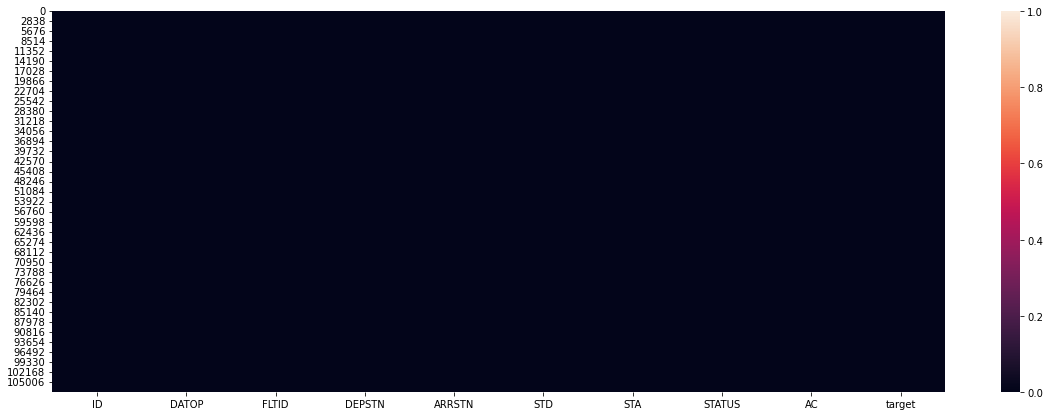

In [10]:
#check missing values in train data
fig, ax = plt.subplots(figsize = (20,7))
ax = sns.heatmap(train.isnull(), vmin=0, vmax = 1)

In [11]:

#creating new columns which is the difference between the Stated time of arrival Column and Stated time of departure

duration_train = [(train.STA.loc[i] - train.STD.loc[i]).total_seconds()/60 for i in range(train.shape[0])]

duration_test = [(test.STA.loc[i] - test.STD.loc[i]).total_seconds()/60 for i in range(test.shape[0])]

In [12]:
train['flight_duration'] = duration_train  #This creates a new column in train dataset
test['flight_duration'] = duration_test  #This creates a new column in train dataset
train.head()

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target,flight_duration
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12:55:00,ATA,TU 32AIMN,260.0,145.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,20.0,110.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,0.0,155.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,0.0,170.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,TU 320IMU,22.0,80.0


In [13]:
# splitting DATOP into  month, day,year
train['day_of_week']=train["DATOP"].dt.dayofweek
train['month_of_year']=train["DATOP"].dt.month
train['year']=train["DATOP"].dt.year

#splitting STD into hours
train['std_hr'] = pd.to_datetime(train['STD']).dt.hour

#splitting STA into hours
train['sta_hr'] = pd.to_datetime(train['STA']).dt.hour


# splitting DATOP into  month, day,year
test['day_of_week']=test["DATOP"].dt.dayofweek
test['month_of_year']=test["DATOP"].dt.month
test['year']=test["DATOP"].dt.year


#splitting STD into hours 
test['std_hr'] = pd.to_datetime(test['STD']).dt.hour

#splitting STA into hours
test['sta_hr'] = pd.to_datetime(test['STA']).dt.hour

In [14]:
test

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,flight_duration,day_of_week,month_of_year,year,std_hr,sta_hr
0,test_id_0,2016-05-04,TU 0700,DJE,TUN,2016-05-04 06:40:00,2016-05-04 07:30:00,ATA,TU 32AIMF,50.0,2,5,2016,6,7
1,test_id_1,2016-05-05,TU 0395,TUN,BKO,2016-05-05 15:20:00,2016-05-05 20:05:00,ATA,TU 320IMW,285.0,3,5,2016,15,20
2,test_id_2,2016-05-06,TU 0745,FRA,TUN,2016-05-06 10:00:00,2016-05-06 12:25:00,ATA,TU 32AIMC,145.0,4,5,2016,10,12
3,test_id_3,2016-05-11,TU 0848,BEY,TUN,2016-05-11 09:40:00,2016-05-11 13:10:00,ATA,TU 31BIMO,210.0,2,5,2016,9,13
4,test_id_4,2016-05-11,TU 0635,ORY,MIR,2016-05-11 09:50:00,2016-05-11 12:35:00,ATA,TU 736IOQ,165.0,2,5,2016,9,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9328,test_id_9328,2018-09-12,TU 0998,TUN,NCE,2018-09-12 14:15:00,2018-09-12 15:45:00,ATA,TU 320IMV,90.0,2,9,2018,14,15
9329,test_id_9329,2018-09-27,WKL 0000,TUN,TUN,2018-09-27 22:00:00,2018-09-28 01:00:00,SCH,TU 32AIMG,180.0,3,9,2018,22,1
9330,test_id_9330,2018-09-03,UG 1601,SJJ,TUN,2018-09-03 09:20:00,2018-09-03 11:10:00,SCH,TU CR9ISA,110.0,0,9,2018,9,11
9331,test_id_9331,2018-09-15,UG 0008,TUN,DJE,2018-09-15 14:30:00,2018-09-15 15:30:00,SCH,UG AT7LBD,60.0,5,9,2018,14,15


In [15]:
train

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target,flight_duration,day_of_week,month_of_year,year,std_hr,sta_hr
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12:55:00,ATA,TU 32AIMN,260.0,145.0,6,1,2016,10,12
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16:55:00,ATA,TU 31BIMO,20.0,110.0,2,1,2016,15,16
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06:45:00,ATA,TU 32AIMN,0.0,155.0,5,1,2016,4,6
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17:00:00,ATA,TU 736IOK,0.0,170.0,6,1,2016,14,17
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15:50:00,ATA,TU 320IMU,22.0,80.0,6,1,2016,14,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107828,train_id_107828,2018-07-05,WKL 0000,TUN,TUN,2018-07-05 23:00:00,2018-07-06 02:00:00,SCH,TU 32AIML,0.0,180.0,3,7,2018,23,2
107829,train_id_107829,2018-01-13,UG 0003,DJE,TUN,2018-01-13 08:00:00,2018-01-13 09:00:00,SCH,UG AT7AT7,0.0,60.0,5,1,2018,8,9
107830,train_id_107830,2018-11-07,SGT 0000,TUN,TUN,2018-11-07 05:00:00,2018-11-07 12:50:00,SCH,TU 736IOK,0.0,470.0,2,11,2018,5,12
107831,train_id_107831,2018-01-23,UG 0010,TUN,DJE,2018-01-23 18:00:00,2018-01-23 18:45:00,ATA,TU CR9ISA,0.0,45.0,1,1,2018,18,18


##  Feature Engineering 

In [16]:
#check for no of unique columns

for name in train.columns:
    unique_values = train[name].nunique()
    print(f"Feature '{name}' has '{unique_values}' unique values")

Feature 'ID' has '107833' unique values
Feature 'DATOP' has '1011' unique values
Feature 'FLTID' has '1861' unique values
Feature 'DEPSTN' has '132' unique values
Feature 'ARRSTN' has '128' unique values
Feature 'STD' has '81697' unique values
Feature 'STA' has '85136' unique values
Feature 'STATUS' has '5' unique values
Feature 'AC' has '68' unique values
Feature 'target' has '968' unique values
Feature 'flight_duration' has '764' unique values
Feature 'day_of_week' has '7' unique values
Feature 'month_of_year' has '12' unique values
Feature 'year' has '3' unique values
Feature 'std_hr' has '24' unique values
Feature 'sta_hr' has '24' unique values


In [17]:
#check for no of unique columns

for name in test.columns:
    unique_values = test[name].nunique()
    print(f"Feature '{name}' has '{unique_values}' unique values")

Feature 'ID' has '9333' unique values
Feature 'DATOP' has '86' unique values
Feature 'FLTID' has '700' unique values
Feature 'DEPSTN' has '82' unique values
Feature 'ARRSTN' has '84' unique values
Feature 'STD' has '7012' unique values
Feature 'STA' has '7290' unique values
Feature 'STATUS' has '5' unique values
Feature 'AC' has '44' unique values
Feature 'flight_duration' has '163' unique values
Feature 'day_of_week' has '7' unique values
Feature 'month_of_year' has '3' unique values
Feature 'year' has '3' unique values
Feature 'std_hr' has '24' unique values
Feature 'sta_hr' has '24' unique values


In [18]:
test2=test.copy()

In [19]:
le = LabelEncoder()

# function to preprocess our data from train models
def preprocess_data(data):

    
    # categorical features to be onverted to One Hot Encoding
    categ = ['STATUS',]
    
    #Encoding categorical Data
    data['STATUS'] = le.fit_transform(data['STATUS'])
    data['DEPSTN'] = le.fit_transform(data['DEPSTN'])    
    data['ARRSTN'] = le.fit_transform(data['ARRSTN'])    
    data['AC'] = le.fit_transform(data['AC'])    
    data['STATUS'] = le.fit_transform(data['STATUS'])    
    data['STATUS'] = le.fit_transform(data['STATUS'])
    
    
    # drop uniquid column
    data = data.drop(["ID"], axis=1)
    data = data.drop(["FLTID"], axis=1)       
    data = data.drop(["DATOP"], axis=1)
    data = data.drop(['STD'], axis=1)    
    data = data.drop(['STA'], axis=1)

    
    
    return data 

In [20]:
#Separate training features from target
X_train  = train.drop(columns=[ 'target'])
y_train  = train['target']

In [21]:
# preprocess the data 
train = preprocess_data(X_train)
test = preprocess_data(test)

In [22]:
# Split train_data
from sklearn.model_selection import train_test_split

X_Train, X_Val, y_Train, y_val = train_test_split(train, y_train, 
                                                  test_size = 0.1, random_state=42)

## model building using CATBoost

In [27]:
model = CatBoostRegressor(learning_rate= 0.05, max_depth= 3, n_estimators= 600, od_wait= 50, reg_lambda= 3, subsample= 0.6)

In [24]:
kf =KFold(5, shuffle=True, random_state=1)

In [48]:
cross_val_score(model,X_Train,y_Train,cv=kf,scoring='neg_root_mean_squared_error')

0:	learn: 115.9350462	total: 9.74ms	remaining: 5.84s
1:	learn: 115.6988515	total: 18.3ms	remaining: 5.48s
2:	learn: 115.4895041	total: 26.9ms	remaining: 5.35s
3:	learn: 115.2855490	total: 35.2ms	remaining: 5.24s
4:	learn: 115.1281626	total: 44.3ms	remaining: 5.28s
5:	learn: 114.9558150	total: 52.9ms	remaining: 5.24s
6:	learn: 114.8031987	total: 61.3ms	remaining: 5.19s
7:	learn: 114.6662757	total: 69.4ms	remaining: 5.13s
8:	learn: 114.5438745	total: 78.2ms	remaining: 5.14s
9:	learn: 114.4308188	total: 86.6ms	remaining: 5.11s
10:	learn: 114.3282615	total: 96.5ms	remaining: 5.17s
11:	learn: 114.2410693	total: 104ms	remaining: 5.11s
12:	learn: 114.1589901	total: 112ms	remaining: 5.06s
13:	learn: 114.0760052	total: 120ms	remaining: 5.02s
14:	learn: 113.9985528	total: 128ms	remaining: 4.99s
15:	learn: 113.9321050	total: 136ms	remaining: 4.96s
16:	learn: 113.8675472	total: 144ms	remaining: 4.93s
17:	learn: 113.8016928	total: 152ms	remaining: 4.9s
18:	learn: 113.7446381	total: 160ms	remaining:

161:	learn: 111.5218989	total: 1.4s	remaining: 3.79s
162:	learn: 111.5179870	total: 1.41s	remaining: 3.79s
163:	learn: 111.5134090	total: 1.42s	remaining: 3.78s
164:	learn: 111.5084892	total: 1.43s	remaining: 3.77s
165:	learn: 111.5038376	total: 1.44s	remaining: 3.76s
166:	learn: 111.4945704	total: 1.45s	remaining: 3.75s
167:	learn: 111.4894058	total: 1.46s	remaining: 3.74s
168:	learn: 111.4853072	total: 1.46s	remaining: 3.73s
169:	learn: 111.4814688	total: 1.47s	remaining: 3.73s
170:	learn: 111.4746083	total: 1.48s	remaining: 3.71s
171:	learn: 111.4679696	total: 1.49s	remaining: 3.7s
172:	learn: 111.4580581	total: 1.5s	remaining: 3.69s
173:	learn: 111.4531149	total: 1.5s	remaining: 3.68s
174:	learn: 111.4488566	total: 1.51s	remaining: 3.67s
175:	learn: 111.4416133	total: 1.52s	remaining: 3.67s
176:	learn: 111.4356144	total: 1.53s	remaining: 3.66s
177:	learn: 111.4325424	total: 1.54s	remaining: 3.65s
178:	learn: 111.4238090	total: 1.54s	remaining: 3.63s
179:	learn: 111.4182547	total: 1

334:	learn: 110.6633639	total: 2.95s	remaining: 2.33s
335:	learn: 110.6588631	total: 2.96s	remaining: 2.33s
336:	learn: 110.6544962	total: 2.97s	remaining: 2.32s
337:	learn: 110.6501081	total: 2.98s	remaining: 2.31s
338:	learn: 110.6470162	total: 2.99s	remaining: 2.3s
339:	learn: 110.6425970	total: 2.99s	remaining: 2.29s
340:	learn: 110.6390617	total: 3s	remaining: 2.28s
341:	learn: 110.6361991	total: 3.01s	remaining: 2.27s
342:	learn: 110.6320541	total: 3.02s	remaining: 2.26s
343:	learn: 110.6263373	total: 3.03s	remaining: 2.25s
344:	learn: 110.6226772	total: 3.04s	remaining: 2.24s
345:	learn: 110.6191329	total: 3.04s	remaining: 2.23s
346:	learn: 110.6151482	total: 3.05s	remaining: 2.23s
347:	learn: 110.6117450	total: 3.06s	remaining: 2.22s
348:	learn: 110.6085942	total: 3.07s	remaining: 2.21s
349:	learn: 110.6033803	total: 3.08s	remaining: 2.2s
350:	learn: 110.5993946	total: 3.09s	remaining: 2.19s
351:	learn: 110.5957971	total: 3.1s	remaining: 2.18s
352:	learn: 110.5908042	total: 3.1

489:	learn: 110.1522857	total: 4.3s	remaining: 966ms
490:	learn: 110.1484746	total: 4.31s	remaining: 958ms
491:	learn: 110.1449764	total: 4.32s	remaining: 949ms
492:	learn: 110.1422228	total: 4.33s	remaining: 940ms
493:	learn: 110.1401246	total: 4.34s	remaining: 932ms
494:	learn: 110.1386057	total: 4.35s	remaining: 923ms
495:	learn: 110.1361828	total: 4.36s	remaining: 914ms
496:	learn: 110.1329608	total: 4.37s	remaining: 905ms
497:	learn: 110.1305487	total: 4.37s	remaining: 896ms
498:	learn: 110.1280097	total: 4.38s	remaining: 887ms
499:	learn: 110.1223361	total: 4.39s	remaining: 878ms
500:	learn: 110.1190018	total: 4.4s	remaining: 869ms
501:	learn: 110.1145575	total: 4.41s	remaining: 860ms
502:	learn: 110.1102987	total: 4.42s	remaining: 852ms
503:	learn: 110.1066983	total: 4.42s	remaining: 843ms
504:	learn: 110.1047856	total: 4.43s	remaining: 834ms
505:	learn: 110.1028919	total: 4.44s	remaining: 825ms
506:	learn: 110.1006713	total: 4.45s	remaining: 816ms
507:	learn: 110.0987585	total:

61:	learn: 115.7291815	total: 581ms	remaining: 5.04s
62:	learn: 115.7146242	total: 593ms	remaining: 5.06s
63:	learn: 115.6992677	total: 602ms	remaining: 5.04s
64:	learn: 115.6824890	total: 614ms	remaining: 5.05s
65:	learn: 115.6666719	total: 623ms	remaining: 5.04s
66:	learn: 115.6528669	total: 633ms	remaining: 5.04s
67:	learn: 115.6302067	total: 643ms	remaining: 5.03s
68:	learn: 115.6193724	total: 652ms	remaining: 5.02s
69:	learn: 115.6075409	total: 661ms	remaining: 5s
70:	learn: 115.5913885	total: 670ms	remaining: 4.99s
71:	learn: 115.5816052	total: 679ms	remaining: 4.98s
72:	learn: 115.5716009	total: 688ms	remaining: 4.97s
73:	learn: 115.5605656	total: 697ms	remaining: 4.95s
74:	learn: 115.5420015	total: 705ms	remaining: 4.94s
75:	learn: 115.5194222	total: 716ms	remaining: 4.93s
76:	learn: 115.5009059	total: 726ms	remaining: 4.93s
77:	learn: 115.4886775	total: 735ms	remaining: 4.92s
78:	learn: 115.4789622	total: 744ms	remaining: 4.91s
79:	learn: 115.4667069	total: 754ms	remaining: 4.

219:	learn: 114.4545550	total: 1.98s	remaining: 3.42s
220:	learn: 114.4418495	total: 1.99s	remaining: 3.42s
221:	learn: 114.4376669	total: 2s	remaining: 3.41s
222:	learn: 114.4347797	total: 2.01s	remaining: 3.4s
223:	learn: 114.4300123	total: 2.02s	remaining: 3.39s
224:	learn: 114.4243522	total: 2.02s	remaining: 3.38s
225:	learn: 114.4199720	total: 2.03s	remaining: 3.37s
226:	learn: 114.4153625	total: 2.04s	remaining: 3.35s
227:	learn: 114.4099240	total: 2.05s	remaining: 3.35s
228:	learn: 114.4064448	total: 2.06s	remaining: 3.33s
229:	learn: 114.4031800	total: 2.06s	remaining: 3.32s
230:	learn: 114.3994410	total: 2.07s	remaining: 3.31s
231:	learn: 114.3963090	total: 2.08s	remaining: 3.3s
232:	learn: 114.3903866	total: 2.09s	remaining: 3.29s
233:	learn: 114.3858976	total: 2.1s	remaining: 3.28s
234:	learn: 114.3817488	total: 2.1s	remaining: 3.27s
235:	learn: 114.3766621	total: 2.11s	remaining: 3.26s
236:	learn: 114.3692918	total: 2.12s	remaining: 3.25s
237:	learn: 114.3655298	total: 2.13

376:	learn: 113.7747853	total: 3.37s	remaining: 1.99s
377:	learn: 113.7728898	total: 3.38s	remaining: 1.98s
378:	learn: 113.7684284	total: 3.38s	remaining: 1.97s
379:	learn: 113.7658324	total: 3.4s	remaining: 1.97s
380:	learn: 113.7608494	total: 3.4s	remaining: 1.96s
381:	learn: 113.7560503	total: 3.41s	remaining: 1.95s
382:	learn: 113.7542552	total: 3.42s	remaining: 1.94s
383:	learn: 113.7515932	total: 3.43s	remaining: 1.93s
384:	learn: 113.7487398	total: 3.43s	remaining: 1.92s
385:	learn: 113.7448242	total: 3.44s	remaining: 1.91s
386:	learn: 113.7406739	total: 3.45s	remaining: 1.9s
387:	learn: 113.7378893	total: 3.45s	remaining: 1.89s
388:	learn: 113.7342868	total: 3.46s	remaining: 1.88s
389:	learn: 113.7310320	total: 3.46s	remaining: 1.86s
390:	learn: 113.7287750	total: 3.47s	remaining: 1.85s
391:	learn: 113.7268813	total: 3.48s	remaining: 1.84s
392:	learn: 113.7214647	total: 3.48s	remaining: 1.83s
393:	learn: 113.7183836	total: 3.49s	remaining: 1.82s
394:	learn: 113.7158813	total: 

539:	learn: 113.2151335	total: 4.52s	remaining: 502ms
540:	learn: 113.2134046	total: 4.53s	remaining: 494ms
541:	learn: 113.2103600	total: 4.54s	remaining: 485ms
542:	learn: 113.2091717	total: 4.54s	remaining: 477ms
543:	learn: 113.2056452	total: 4.55s	remaining: 469ms
544:	learn: 113.2018751	total: 4.56s	remaining: 460ms
545:	learn: 113.1997813	total: 4.57s	remaining: 452ms
546:	learn: 113.1952046	total: 4.57s	remaining: 443ms
547:	learn: 113.1926169	total: 4.58s	remaining: 435ms
548:	learn: 113.1892503	total: 4.58s	remaining: 426ms
549:	learn: 113.1864022	total: 4.59s	remaining: 417ms
550:	learn: 113.1843187	total: 4.6s	remaining: 409ms
551:	learn: 113.1816750	total: 4.61s	remaining: 400ms
552:	learn: 113.1790438	total: 4.61s	remaining: 392ms
553:	learn: 113.1766353	total: 4.62s	remaining: 384ms
554:	learn: 113.1688700	total: 4.63s	remaining: 375ms
555:	learn: 113.1671447	total: 4.64s	remaining: 367ms
556:	learn: 113.1662501	total: 4.64s	remaining: 359ms
557:	learn: 113.1641724	total

103:	learn: 111.9636579	total: 772ms	remaining: 3.68s
104:	learn: 111.9553392	total: 780ms	remaining: 3.68s
105:	learn: 111.9449641	total: 791ms	remaining: 3.69s
106:	learn: 111.9355418	total: 802ms	remaining: 3.69s
107:	learn: 111.9253482	total: 811ms	remaining: 3.69s
108:	learn: 111.9157756	total: 819ms	remaining: 3.69s
109:	learn: 111.9098679	total: 827ms	remaining: 3.68s
110:	learn: 111.9023982	total: 834ms	remaining: 3.67s
111:	learn: 111.8919456	total: 840ms	remaining: 3.66s
112:	learn: 111.8784686	total: 847ms	remaining: 3.65s
113:	learn: 111.8733595	total: 853ms	remaining: 3.64s
114:	learn: 111.8636783	total: 860ms	remaining: 3.63s
115:	learn: 111.8578508	total: 867ms	remaining: 3.62s
116:	learn: 111.8494261	total: 873ms	remaining: 3.6s
117:	learn: 111.8404966	total: 879ms	remaining: 3.59s
118:	learn: 111.8320006	total: 886ms	remaining: 3.58s
119:	learn: 111.8227624	total: 893ms	remaining: 3.57s
120:	learn: 111.8134116	total: 900ms	remaining: 3.56s
121:	learn: 111.8077885	total

257:	learn: 110.9944099	total: 1.9s	remaining: 2.52s
258:	learn: 110.9912100	total: 1.91s	remaining: 2.51s
259:	learn: 110.9880350	total: 1.91s	remaining: 2.5s
260:	learn: 110.9837131	total: 1.92s	remaining: 2.5s
261:	learn: 110.9799702	total: 1.93s	remaining: 2.49s
262:	learn: 110.9727254	total: 1.94s	remaining: 2.48s
263:	learn: 110.9666807	total: 1.95s	remaining: 2.48s
264:	learn: 110.9609985	total: 1.95s	remaining: 2.47s
265:	learn: 110.9541523	total: 1.96s	remaining: 2.46s
266:	learn: 110.9500366	total: 1.97s	remaining: 2.45s
267:	learn: 110.9446602	total: 1.98s	remaining: 2.45s
268:	learn: 110.9411228	total: 1.98s	remaining: 2.44s
269:	learn: 110.9360197	total: 1.99s	remaining: 2.43s
270:	learn: 110.9303519	total: 2s	remaining: 2.43s
271:	learn: 110.9267978	total: 2.01s	remaining: 2.42s
272:	learn: 110.9205789	total: 2.02s	remaining: 2.42s
273:	learn: 110.9141116	total: 2.03s	remaining: 2.41s
274:	learn: 110.9090087	total: 2.03s	remaining: 2.4s
275:	learn: 110.9066567	total: 2.04

432:	learn: 110.3229276	total: 3.2s	remaining: 1.23s
433:	learn: 110.3206148	total: 3.21s	remaining: 1.23s
434:	learn: 110.3179216	total: 3.22s	remaining: 1.22s
435:	learn: 110.3155589	total: 3.23s	remaining: 1.22s
436:	learn: 110.3126730	total: 3.24s	remaining: 1.21s
437:	learn: 110.3075089	total: 3.25s	remaining: 1.2s
438:	learn: 110.3024792	total: 3.25s	remaining: 1.19s
439:	learn: 110.2983274	total: 3.26s	remaining: 1.19s
440:	learn: 110.2957555	total: 3.27s	remaining: 1.18s
441:	learn: 110.2943867	total: 3.27s	remaining: 1.17s
442:	learn: 110.2915704	total: 3.28s	remaining: 1.16s
443:	learn: 110.2894223	total: 3.29s	remaining: 1.15s
444:	learn: 110.2866904	total: 3.29s	remaining: 1.15s
445:	learn: 110.2809966	total: 3.3s	remaining: 1.14s
446:	learn: 110.2764850	total: 3.31s	remaining: 1.13s
447:	learn: 110.2747733	total: 3.31s	remaining: 1.12s
448:	learn: 110.2711934	total: 3.32s	remaining: 1.12s
449:	learn: 110.2693967	total: 3.32s	remaining: 1.11s
450:	learn: 110.2649517	total: 

596:	learn: 109.8145438	total: 4.51s	remaining: 22.7ms
597:	learn: 109.8126421	total: 4.52s	remaining: 15.1ms
598:	learn: 109.8096445	total: 4.53s	remaining: 7.56ms
599:	learn: 109.8066142	total: 4.54s	remaining: 0us
0:	learn: 116.3337204	total: 13.5ms	remaining: 8.09s
1:	learn: 116.0949008	total: 23.8ms	remaining: 7.12s
2:	learn: 115.8846800	total: 32ms	remaining: 6.38s
3:	learn: 115.6810640	total: 39.4ms	remaining: 5.87s
4:	learn: 115.5184308	total: 46ms	remaining: 5.48s
5:	learn: 115.3453537	total: 52.4ms	remaining: 5.18s
6:	learn: 115.1940745	total: 59.5ms	remaining: 5.04s
7:	learn: 115.0582765	total: 65.9ms	remaining: 4.88s
8:	learn: 114.9358660	total: 72.3ms	remaining: 4.75s
9:	learn: 114.8270633	total: 78.6ms	remaining: 4.63s
10:	learn: 114.7182577	total: 85ms	remaining: 4.55s
11:	learn: 114.6347259	total: 92.3ms	remaining: 4.52s
12:	learn: 114.5488394	total: 100ms	remaining: 4.53s
13:	learn: 114.4599184	total: 107ms	remaining: 4.49s
14:	learn: 114.3847083	total: 114ms	remaining

171:	learn: 111.9226054	total: 1.3s	remaining: 3.23s
172:	learn: 111.9170995	total: 1.31s	remaining: 3.23s
173:	learn: 111.9108121	total: 1.31s	remaining: 3.22s
174:	learn: 111.9037007	total: 1.32s	remaining: 3.22s
175:	learn: 111.8981260	total: 1.33s	remaining: 3.21s
176:	learn: 111.8925384	total: 1.34s	remaining: 3.21s
177:	learn: 111.8884456	total: 1.35s	remaining: 3.2s
178:	learn: 111.8836245	total: 1.36s	remaining: 3.2s
179:	learn: 111.8793781	total: 1.37s	remaining: 3.19s
180:	learn: 111.8749123	total: 1.37s	remaining: 3.18s
181:	learn: 111.8706300	total: 1.38s	remaining: 3.17s
182:	learn: 111.8667889	total: 1.39s	remaining: 3.16s
183:	learn: 111.8590779	total: 1.39s	remaining: 3.15s
184:	learn: 111.8551018	total: 1.4s	remaining: 3.15s
185:	learn: 111.8501735	total: 1.41s	remaining: 3.14s
186:	learn: 111.8466842	total: 1.42s	remaining: 3.14s
187:	learn: 111.8401429	total: 1.43s	remaining: 3.13s
188:	learn: 111.8346404	total: 1.44s	remaining: 3.13s
189:	learn: 111.8294756	total: 1

345:	learn: 111.1607826	total: 2.61s	remaining: 1.91s
346:	learn: 111.1578376	total: 2.62s	remaining: 1.91s
347:	learn: 111.1533021	total: 2.63s	remaining: 1.9s
348:	learn: 111.1496379	total: 2.63s	remaining: 1.9s
349:	learn: 111.1468365	total: 2.65s	remaining: 1.89s
350:	learn: 111.1427051	total: 2.66s	remaining: 1.89s
351:	learn: 111.1368493	total: 2.67s	remaining: 1.88s
352:	learn: 111.1332714	total: 2.67s	remaining: 1.87s
353:	learn: 111.1293026	total: 2.68s	remaining: 1.86s
354:	learn: 111.1242036	total: 2.69s	remaining: 1.86s
355:	learn: 111.1220298	total: 2.7s	remaining: 1.85s
356:	learn: 111.1190623	total: 2.7s	remaining: 1.84s
357:	learn: 111.1146156	total: 2.71s	remaining: 1.83s
358:	learn: 111.1127172	total: 2.71s	remaining: 1.82s
359:	learn: 111.1104518	total: 2.72s	remaining: 1.81s
360:	learn: 111.1082083	total: 2.73s	remaining: 1.8s
361:	learn: 111.1060370	total: 2.73s	remaining: 1.8s
362:	learn: 111.1026199	total: 2.74s	remaining: 1.79s
363:	learn: 111.0986765	total: 2.7

516:	learn: 110.6237707	total: 3.91s	remaining: 628ms
517:	learn: 110.6220605	total: 3.92s	remaining: 620ms
518:	learn: 110.6204348	total: 3.93s	remaining: 613ms
519:	learn: 110.6179446	total: 3.93s	remaining: 605ms
520:	learn: 110.6151554	total: 3.94s	remaining: 597ms
521:	learn: 110.6127655	total: 3.95s	remaining: 590ms
522:	learn: 110.6106855	total: 3.96s	remaining: 582ms
523:	learn: 110.6082332	total: 3.96s	remaining: 575ms
524:	learn: 110.6026986	total: 3.97s	remaining: 567ms
525:	learn: 110.5993364	total: 3.98s	remaining: 559ms
526:	learn: 110.5973827	total: 3.98s	remaining: 552ms
527:	learn: 110.5947875	total: 3.99s	remaining: 544ms
528:	learn: 110.5920173	total: 4s	remaining: 536ms
529:	learn: 110.5901352	total: 4s	remaining: 529ms
530:	learn: 110.5884505	total: 4.01s	remaining: 521ms
531:	learn: 110.5865736	total: 4.01s	remaining: 513ms
532:	learn: 110.5849833	total: 4.02s	remaining: 506ms
533:	learn: 110.5829420	total: 4.03s	remaining: 498ms
534:	learn: 110.5808405	total: 4.0

78:	learn: 114.3651699	total: 575ms	remaining: 3.79s
79:	learn: 114.3529983	total: 583ms	remaining: 3.79s
80:	learn: 114.3404483	total: 591ms	remaining: 3.79s
81:	learn: 114.3276343	total: 598ms	remaining: 3.78s
82:	learn: 114.3140764	total: 606ms	remaining: 3.77s
83:	learn: 114.3016434	total: 614ms	remaining: 3.77s
84:	learn: 114.2924128	total: 621ms	remaining: 3.76s
85:	learn: 114.2799845	total: 628ms	remaining: 3.75s
86:	learn: 114.2650827	total: 637ms	remaining: 3.75s
87:	learn: 114.2470774	total: 643ms	remaining: 3.74s
88:	learn: 114.2361097	total: 650ms	remaining: 3.73s
89:	learn: 114.2239226	total: 657ms	remaining: 3.72s
90:	learn: 114.2107523	total: 663ms	remaining: 3.71s
91:	learn: 114.1980843	total: 669ms	remaining: 3.7s
92:	learn: 114.1905892	total: 675ms	remaining: 3.68s
93:	learn: 114.1817782	total: 682ms	remaining: 3.67s
94:	learn: 114.1727727	total: 688ms	remaining: 3.66s
95:	learn: 114.1609188	total: 696ms	remaining: 3.65s
96:	learn: 114.1515437	total: 704ms	remaining: 

234:	learn: 113.2874644	total: 1.72s	remaining: 2.67s
235:	learn: 113.2828167	total: 1.73s	remaining: 2.67s
236:	learn: 113.2775671	total: 1.74s	remaining: 2.66s
237:	learn: 113.2724337	total: 1.74s	remaining: 2.65s
238:	learn: 113.2694551	total: 1.75s	remaining: 2.64s
239:	learn: 113.2643467	total: 1.76s	remaining: 2.64s
240:	learn: 113.2599358	total: 1.76s	remaining: 2.63s
241:	learn: 113.2538394	total: 1.77s	remaining: 2.62s
242:	learn: 113.2463807	total: 1.78s	remaining: 2.61s
243:	learn: 113.2408069	total: 1.78s	remaining: 2.6s
244:	learn: 113.2357903	total: 1.79s	remaining: 2.6s
245:	learn: 113.2329665	total: 1.8s	remaining: 2.59s
246:	learn: 113.2292092	total: 1.8s	remaining: 2.58s
247:	learn: 113.2221213	total: 1.81s	remaining: 2.57s
248:	learn: 113.2175515	total: 1.82s	remaining: 2.56s
249:	learn: 113.2128562	total: 1.82s	remaining: 2.55s
250:	learn: 113.2093834	total: 1.83s	remaining: 2.54s
251:	learn: 113.2051771	total: 1.84s	remaining: 2.54s
252:	learn: 113.2014385	total: 1

393:	learn: 112.6364945	total: 2.83s	remaining: 1.48s
394:	learn: 112.6329038	total: 2.84s	remaining: 1.48s
395:	learn: 112.6305818	total: 2.85s	remaining: 1.47s
396:	learn: 112.6268914	total: 2.86s	remaining: 1.46s
397:	learn: 112.6231306	total: 2.86s	remaining: 1.45s
398:	learn: 112.6192093	total: 2.87s	remaining: 1.45s
399:	learn: 112.6137756	total: 2.88s	remaining: 1.44s
400:	learn: 112.6117445	total: 2.88s	remaining: 1.43s
401:	learn: 112.6082241	total: 2.89s	remaining: 1.43s
402:	learn: 112.6059006	total: 2.9s	remaining: 1.42s
403:	learn: 112.6038684	total: 2.91s	remaining: 1.41s
404:	learn: 112.6012117	total: 2.92s	remaining: 1.4s
405:	learn: 112.5956942	total: 2.92s	remaining: 1.4s
406:	learn: 112.5924113	total: 2.93s	remaining: 1.39s
407:	learn: 112.5890016	total: 2.94s	remaining: 1.38s
408:	learn: 112.5852043	total: 2.95s	remaining: 1.38s
409:	learn: 112.5816364	total: 2.96s	remaining: 1.37s
410:	learn: 112.5781091	total: 2.96s	remaining: 1.36s
411:	learn: 112.5743403	total: 

547:	learn: 112.1851131	total: 3.96s	remaining: 375ms
548:	learn: 112.1826405	total: 3.96s	remaining: 368ms
549:	learn: 112.1802248	total: 3.97s	remaining: 361ms
550:	learn: 112.1781905	total: 3.98s	remaining: 354ms
551:	learn: 112.1755053	total: 3.99s	remaining: 347ms
552:	learn: 112.1724497	total: 3.99s	remaining: 339ms
553:	learn: 112.1703669	total: 4s	remaining: 332ms
554:	learn: 112.1690298	total: 4.01s	remaining: 325ms
555:	learn: 112.1657009	total: 4.01s	remaining: 318ms
556:	learn: 112.1586686	total: 4.02s	remaining: 310ms
557:	learn: 112.1567140	total: 4.03s	remaining: 303ms
558:	learn: 112.1548562	total: 4.03s	remaining: 296ms
559:	learn: 112.1521146	total: 4.04s	remaining: 288ms
560:	learn: 112.1499627	total: 4.04s	remaining: 281ms
561:	learn: 112.1475433	total: 4.05s	remaining: 274ms
562:	learn: 112.1447952	total: 4.06s	remaining: 267ms
563:	learn: 112.1421517	total: 4.06s	remaining: 259ms
564:	learn: 112.1404288	total: 4.07s	remaining: 252ms
565:	learn: 112.1388363	total: 

array([-116.52862882, -103.17044292, -116.49456479, -114.64193207,
       -107.97020454])

In [60]:
model.fit(X_Train,y_Train,use_best_model = True)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 117.0609283	total: 13.8ms	remaining: 55.2s
1:	learn: 116.7795957	total: 26.4ms	remaining: 52.8s
2:	learn: 116.5373520	total: 38.9ms	remaining: 51.8s
3:	learn: 116.2982821	total: 51.6ms	remaining: 51.6s
4:	learn: 116.0805513	total: 64.5ms	remaining: 51.5s
5:	learn: 115.8799970	total: 76.4ms	remaining: 50.9s
6:	learn: 115.6912108	total: 88.3ms	remaining: 50.3s
7:	learn: 115.5206288	total: 101ms	remaining: 50.2s
8:	learn: 115.3769367	total: 113ms	remaining: 50.2s
9:	learn: 115.2350869	total: 126ms	remaining: 50.2s
10:	learn: 115.1042736	total: 138ms	remaining: 50s
11:	learn: 114.9885696	total: 150ms	remaining: 49.8s
12:	learn: 114.8837368	total: 162ms	remaining: 49.8s
13:	learn: 114.7875082	total: 175ms	remaining: 49.9s
14:	learn: 114.6976665	total: 195ms	remaining: 51.8s
15:	learn: 114.6012861	total: 216ms	remaining: 53.7s
16:	learn: 114.5226326	total: 228ms	remaining: 53.4s
17:	learn: 114.4475327	total: 240ms	remaining: 53.2s
18:	learn: 114.3779304	total: 253ms	remaining: 53.1

160:	learn: 111.6463967	total: 2.05s	remaining: 48.9s
161:	learn: 111.6425361	total: 2.06s	remaining: 48.9s
162:	learn: 111.6336858	total: 2.08s	remaining: 48.9s
163:	learn: 111.6217079	total: 2.09s	remaining: 48.8s
164:	learn: 111.6124698	total: 2.1s	remaining: 48.7s
165:	learn: 111.6032393	total: 2.11s	remaining: 48.7s
166:	learn: 111.5905135	total: 2.12s	remaining: 48.6s
167:	learn: 111.5800715	total: 2.13s	remaining: 48.6s
168:	learn: 111.5717987	total: 2.14s	remaining: 48.5s
169:	learn: 111.5659901	total: 2.15s	remaining: 48.6s
170:	learn: 111.5557585	total: 2.17s	remaining: 48.5s
171:	learn: 111.5488067	total: 2.18s	remaining: 48.5s
172:	learn: 111.5421953	total: 2.2s	remaining: 48.6s
173:	learn: 111.5352125	total: 2.21s	remaining: 48.6s
174:	learn: 111.5238783	total: 2.22s	remaining: 48.6s
175:	learn: 111.5120572	total: 2.24s	remaining: 48.6s
176:	learn: 111.5051654	total: 2.26s	remaining: 48.8s
177:	learn: 111.4989282	total: 2.28s	remaining: 48.9s
178:	learn: 111.4912162	total:

325:	learn: 110.4376886	total: 4.03s	remaining: 45.4s
326:	learn: 110.4313988	total: 4.04s	remaining: 45.4s
327:	learn: 110.4233562	total: 4.05s	remaining: 45.4s
328:	learn: 110.4179993	total: 4.06s	remaining: 45.3s
329:	learn: 110.4148292	total: 4.07s	remaining: 45.3s
330:	learn: 110.4107955	total: 4.08s	remaining: 45.3s
331:	learn: 110.4073184	total: 4.09s	remaining: 45.2s
332:	learn: 110.4029665	total: 4.1s	remaining: 45.2s
333:	learn: 110.3974108	total: 4.11s	remaining: 45.1s
334:	learn: 110.3925294	total: 4.12s	remaining: 45.1s
335:	learn: 110.3872960	total: 4.13s	remaining: 45.1s
336:	learn: 110.3784209	total: 4.14s	remaining: 45s
337:	learn: 110.3708603	total: 4.15s	remaining: 45s
338:	learn: 110.3618699	total: 4.16s	remaining: 45s
339:	learn: 110.3564889	total: 4.17s	remaining: 44.9s
340:	learn: 110.3476142	total: 4.18s	remaining: 44.9s
341:	learn: 110.3422338	total: 4.2s	remaining: 44.9s
342:	learn: 110.3373170	total: 4.21s	remaining: 44.9s
343:	learn: 110.3301317	total: 4.22s

487:	learn: 109.5361312	total: 5.8s	remaining: 41.7s
488:	learn: 109.5293098	total: 5.83s	remaining: 41.8s
489:	learn: 109.5227761	total: 5.84s	remaining: 41.8s
490:	learn: 109.5168240	total: 5.85s	remaining: 41.8s
491:	learn: 109.5132626	total: 5.86s	remaining: 41.8s
492:	learn: 109.5078865	total: 5.87s	remaining: 41.8s
493:	learn: 109.5015897	total: 5.88s	remaining: 41.7s
494:	learn: 109.4949984	total: 5.89s	remaining: 41.7s
495:	learn: 109.4924021	total: 5.9s	remaining: 41.7s
496:	learn: 109.4882598	total: 5.91s	remaining: 41.6s
497:	learn: 109.4841188	total: 5.92s	remaining: 41.6s
498:	learn: 109.4704807	total: 5.93s	remaining: 41.6s
499:	learn: 109.4622008	total: 5.94s	remaining: 41.6s
500:	learn: 109.4530039	total: 5.95s	remaining: 41.5s
501:	learn: 109.4473626	total: 5.96s	remaining: 41.5s
502:	learn: 109.4375261	total: 5.97s	remaining: 41.5s
503:	learn: 109.4313924	total: 5.98s	remaining: 41.5s
504:	learn: 109.4261187	total: 5.99s	remaining: 41.5s
505:	learn: 109.4206728	total:

652:	learn: 108.7087194	total: 7.6s	remaining: 39s
653:	learn: 108.7051365	total: 7.62s	remaining: 39s
654:	learn: 108.7010884	total: 7.63s	remaining: 39s
655:	learn: 108.6945807	total: 7.64s	remaining: 38.9s
656:	learn: 108.6907424	total: 7.65s	remaining: 38.9s
657:	learn: 108.6860736	total: 7.66s	remaining: 38.9s
658:	learn: 108.6817141	total: 7.67s	remaining: 38.9s
659:	learn: 108.6770513	total: 7.68s	remaining: 38.9s
660:	learn: 108.6699326	total: 7.69s	remaining: 38.8s
661:	learn: 108.6656534	total: 7.7s	remaining: 38.8s
662:	learn: 108.6607997	total: 7.71s	remaining: 38.8s
663:	learn: 108.6547296	total: 7.71s	remaining: 38.8s
664:	learn: 108.6520517	total: 7.72s	remaining: 38.7s
665:	learn: 108.6504409	total: 7.73s	remaining: 38.7s
666:	learn: 108.6402678	total: 7.74s	remaining: 38.7s
667:	learn: 108.6371175	total: 7.75s	remaining: 38.7s
668:	learn: 108.6329385	total: 7.76s	remaining: 38.7s
669:	learn: 108.6297458	total: 7.78s	remaining: 38.7s
670:	learn: 108.6244985	total: 7.79s

819:	learn: 108.0049535	total: 9.4s	remaining: 36.5s
820:	learn: 108.0026719	total: 9.42s	remaining: 36.5s
821:	learn: 108.0010742	total: 9.43s	remaining: 36.5s
822:	learn: 107.9969760	total: 9.44s	remaining: 36.4s
823:	learn: 107.9942478	total: 9.45s	remaining: 36.4s
824:	learn: 107.9913286	total: 9.46s	remaining: 36.4s
825:	learn: 107.9898712	total: 9.47s	remaining: 36.4s
826:	learn: 107.9865068	total: 9.48s	remaining: 36.4s
827:	learn: 107.9826735	total: 9.49s	remaining: 36.3s
828:	learn: 107.9770553	total: 9.5s	remaining: 36.3s
829:	learn: 107.9750060	total: 9.51s	remaining: 36.3s
830:	learn: 107.9698649	total: 9.52s	remaining: 36.3s
831:	learn: 107.9623641	total: 9.53s	remaining: 36.3s
832:	learn: 107.9592789	total: 9.54s	remaining: 36.3s
833:	learn: 107.9566192	total: 9.55s	remaining: 36.2s
834:	learn: 107.9554300	total: 9.55s	remaining: 36.2s
835:	learn: 107.9528048	total: 9.56s	remaining: 36.2s
836:	learn: 107.9498051	total: 9.58s	remaining: 36.2s
837:	learn: 107.9486593	total:

984:	learn: 107.4502952	total: 11.1s	remaining: 34.1s
985:	learn: 107.4489134	total: 11.2s	remaining: 34.1s
986:	learn: 107.4451104	total: 11.2s	remaining: 34.1s
987:	learn: 107.4434094	total: 11.2s	remaining: 34.1s
988:	learn: 107.4415603	total: 11.2s	remaining: 34.1s
989:	learn: 107.4367918	total: 11.2s	remaining: 34.1s
990:	learn: 107.4305707	total: 11.2s	remaining: 34.1s
991:	learn: 107.4285585	total: 11.2s	remaining: 34.1s
992:	learn: 107.4257193	total: 11.2s	remaining: 34s
993:	learn: 107.4170382	total: 11.3s	remaining: 34s
994:	learn: 107.4148556	total: 11.3s	remaining: 34s
995:	learn: 107.4120008	total: 11.3s	remaining: 34s
996:	learn: 107.4103759	total: 11.3s	remaining: 34s
997:	learn: 107.4076499	total: 11.3s	remaining: 34s
998:	learn: 107.4041695	total: 11.3s	remaining: 34s
999:	learn: 107.3981895	total: 11.3s	remaining: 33.9s
1000:	learn: 107.3973788	total: 11.3s	remaining: 33.9s
1001:	learn: 107.3945402	total: 11.3s	remaining: 33.9s
1002:	learn: 107.3898866	total: 11.3s	re

1135:	learn: 106.9682256	total: 12.8s	remaining: 32.2s
1136:	learn: 106.9651407	total: 12.8s	remaining: 32.1s
1137:	learn: 106.9645264	total: 12.8s	remaining: 32.1s
1138:	learn: 106.9618909	total: 12.8s	remaining: 32.1s
1139:	learn: 106.9589693	total: 12.8s	remaining: 32.1s
1140:	learn: 106.9573437	total: 12.8s	remaining: 32.1s
1141:	learn: 106.9558051	total: 12.8s	remaining: 32.1s
1142:	learn: 106.9522956	total: 12.8s	remaining: 32.1s
1143:	learn: 106.9497867	total: 12.8s	remaining: 32s
1144:	learn: 106.9491506	total: 12.8s	remaining: 32s
1145:	learn: 106.9461212	total: 12.9s	remaining: 32s
1146:	learn: 106.9419060	total: 12.9s	remaining: 32s
1147:	learn: 106.9366665	total: 12.9s	remaining: 32s
1148:	learn: 106.9336920	total: 12.9s	remaining: 32s
1149:	learn: 106.9312741	total: 12.9s	remaining: 32s
1150:	learn: 106.9292863	total: 12.9s	remaining: 32s
1151:	learn: 106.9269031	total: 12.9s	remaining: 31.9s
1152:	learn: 106.9238583	total: 12.9s	remaining: 31.9s
1153:	learn: 106.9205065	t

1304:	learn: 106.4650516	total: 14.6s	remaining: 30.1s
1305:	learn: 106.4632220	total: 14.6s	remaining: 30.1s
1306:	learn: 106.4599653	total: 14.6s	remaining: 30.1s
1307:	learn: 106.4581245	total: 14.6s	remaining: 30.1s
1308:	learn: 106.4555827	total: 14.6s	remaining: 30.1s
1309:	learn: 106.4491090	total: 14.7s	remaining: 30.1s
1310:	learn: 106.4474106	total: 14.7s	remaining: 30.1s
1311:	learn: 106.4454399	total: 14.7s	remaining: 30.1s
1312:	learn: 106.4449266	total: 14.7s	remaining: 30s
1313:	learn: 106.4425856	total: 14.7s	remaining: 30s
1314:	learn: 106.4388882	total: 14.7s	remaining: 30s
1315:	learn: 106.4358455	total: 14.7s	remaining: 30s
1316:	learn: 106.4339758	total: 14.7s	remaining: 30s
1317:	learn: 106.4319144	total: 14.7s	remaining: 30s
1318:	learn: 106.4207427	total: 14.8s	remaining: 30s
1319:	learn: 106.4202697	total: 14.8s	remaining: 30s
1320:	learn: 106.4175456	total: 14.8s	remaining: 30s
1321:	learn: 106.4153881	total: 14.8s	remaining: 29.9s
1322:	learn: 106.4130280	tot

1455:	learn: 106.0794955	total: 16.2s	remaining: 28.3s
1456:	learn: 106.0763344	total: 16.2s	remaining: 28.3s
1457:	learn: 106.0745432	total: 16.2s	remaining: 28.3s
1458:	learn: 106.0711813	total: 16.3s	remaining: 28.3s
1459:	learn: 106.0692480	total: 16.3s	remaining: 28.3s
1460:	learn: 106.0677052	total: 16.3s	remaining: 28.3s
1461:	learn: 106.0663968	total: 16.3s	remaining: 28.3s
1462:	learn: 106.0638507	total: 16.3s	remaining: 28.3s
1463:	learn: 106.0629354	total: 16.3s	remaining: 28.2s
1464:	learn: 106.0602240	total: 16.3s	remaining: 28.2s
1465:	learn: 106.0586184	total: 16.3s	remaining: 28.2s
1466:	learn: 106.0561475	total: 16.3s	remaining: 28.2s
1467:	learn: 106.0543440	total: 16.4s	remaining: 28.2s
1468:	learn: 106.0527736	total: 16.4s	remaining: 28.2s
1469:	learn: 106.0506395	total: 16.4s	remaining: 28.2s
1470:	learn: 106.0478291	total: 16.4s	remaining: 28.2s
1471:	learn: 106.0448354	total: 16.4s	remaining: 28.2s
1472:	learn: 106.0429174	total: 16.4s	remaining: 28.1s
1473:	lear

1607:	learn: 105.7090849	total: 17.8s	remaining: 26.5s
1608:	learn: 105.7080368	total: 17.9s	remaining: 26.5s
1609:	learn: 105.7061337	total: 17.9s	remaining: 26.5s
1610:	learn: 105.7057166	total: 17.9s	remaining: 26.5s
1611:	learn: 105.7032960	total: 17.9s	remaining: 26.5s
1612:	learn: 105.6983894	total: 17.9s	remaining: 26.5s
1613:	learn: 105.6919328	total: 17.9s	remaining: 26.5s
1614:	learn: 105.6905345	total: 17.9s	remaining: 26.5s
1615:	learn: 105.6884062	total: 17.9s	remaining: 26.4s
1616:	learn: 105.6865223	total: 17.9s	remaining: 26.4s
1617:	learn: 105.6846837	total: 17.9s	remaining: 26.4s
1618:	learn: 105.6825620	total: 18s	remaining: 26.4s
1619:	learn: 105.6782914	total: 18s	remaining: 26.4s
1620:	learn: 105.6752876	total: 18s	remaining: 26.4s
1621:	learn: 105.6729690	total: 18s	remaining: 26.4s
1622:	learn: 105.6711184	total: 18s	remaining: 26.4s
1623:	learn: 105.6696558	total: 18s	remaining: 26.3s
1624:	learn: 105.6667753	total: 18s	remaining: 26.3s
1625:	learn: 105.6644262

1772:	learn: 105.2936763	total: 19.6s	remaining: 24.6s
1773:	learn: 105.2902282	total: 19.6s	remaining: 24.6s
1774:	learn: 105.2883565	total: 19.6s	remaining: 24.6s
1775:	learn: 105.2861226	total: 19.6s	remaining: 24.6s
1776:	learn: 105.2843199	total: 19.7s	remaining: 24.6s
1777:	learn: 105.2837536	total: 19.7s	remaining: 24.6s
1778:	learn: 105.2832504	total: 19.7s	remaining: 24.6s
1779:	learn: 105.2818900	total: 19.7s	remaining: 24.6s
1780:	learn: 105.2816070	total: 19.7s	remaining: 24.5s
1781:	learn: 105.2805273	total: 19.7s	remaining: 24.5s
1782:	learn: 105.2782739	total: 19.7s	remaining: 24.5s
1783:	learn: 105.2776278	total: 19.7s	remaining: 24.5s
1784:	learn: 105.2759636	total: 19.7s	remaining: 24.5s
1785:	learn: 105.2751232	total: 19.7s	remaining: 24.5s
1786:	learn: 105.2723992	total: 19.8s	remaining: 24.5s
1787:	learn: 105.2715083	total: 19.8s	remaining: 24.4s
1788:	learn: 105.2699640	total: 19.8s	remaining: 24.4s
1789:	learn: 105.2688983	total: 19.8s	remaining: 24.4s
1790:	lear

1927:	learn: 104.9763966	total: 21.3s	remaining: 22.8s
1928:	learn: 104.9750837	total: 21.3s	remaining: 22.9s
1929:	learn: 104.9734772	total: 21.3s	remaining: 22.9s
1930:	learn: 104.9714541	total: 21.3s	remaining: 22.8s
1931:	learn: 104.9700374	total: 21.3s	remaining: 22.8s
1932:	learn: 104.9686686	total: 21.3s	remaining: 22.8s
1933:	learn: 104.9672528	total: 21.3s	remaining: 22.8s
1934:	learn: 104.9660339	total: 21.4s	remaining: 22.8s
1935:	learn: 104.9643694	total: 21.4s	remaining: 22.8s
1936:	learn: 104.9624078	total: 21.4s	remaining: 22.8s
1937:	learn: 104.9609542	total: 21.4s	remaining: 22.8s
1938:	learn: 104.9564191	total: 21.4s	remaining: 22.7s
1939:	learn: 104.9548629	total: 21.4s	remaining: 22.7s
1940:	learn: 104.9530467	total: 21.4s	remaining: 22.7s
1941:	learn: 104.9511370	total: 21.4s	remaining: 22.7s
1942:	learn: 104.9478937	total: 21.5s	remaining: 22.7s
1943:	learn: 104.9450510	total: 21.5s	remaining: 22.7s
1944:	learn: 104.9437698	total: 21.5s	remaining: 22.7s
1945:	lear

2093:	learn: 104.6357704	total: 23.1s	remaining: 21s
2094:	learn: 104.6309616	total: 23.1s	remaining: 21s
2095:	learn: 104.6306768	total: 23.1s	remaining: 21s
2096:	learn: 104.6290593	total: 23.1s	remaining: 21s
2097:	learn: 104.6266274	total: 23.1s	remaining: 21s
2098:	learn: 104.6254177	total: 23.1s	remaining: 20.9s
2099:	learn: 104.6230825	total: 23.1s	remaining: 20.9s
2100:	learn: 104.6195264	total: 23.1s	remaining: 20.9s
2101:	learn: 104.6178471	total: 23.2s	remaining: 20.9s
2102:	learn: 104.6166001	total: 23.2s	remaining: 20.9s
2103:	learn: 104.6149718	total: 23.2s	remaining: 20.9s
2104:	learn: 104.6138336	total: 23.2s	remaining: 20.9s
2105:	learn: 104.6125591	total: 23.2s	remaining: 20.9s
2106:	learn: 104.6120190	total: 23.2s	remaining: 20.9s
2107:	learn: 104.6115721	total: 23.2s	remaining: 20.9s
2108:	learn: 104.6093164	total: 23.2s	remaining: 20.8s
2109:	learn: 104.6086219	total: 23.3s	remaining: 20.8s
2110:	learn: 104.6073416	total: 23.3s	remaining: 20.8s
2111:	learn: 104.604

2244:	learn: 104.3259998	total: 24.7s	remaining: 19.3s
2245:	learn: 104.3254935	total: 24.7s	remaining: 19.3s
2246:	learn: 104.3244516	total: 24.7s	remaining: 19.3s
2247:	learn: 104.3229774	total: 24.7s	remaining: 19.3s
2248:	learn: 104.3214546	total: 24.7s	remaining: 19.3s
2249:	learn: 104.3197678	total: 24.8s	remaining: 19.3s
2250:	learn: 104.3166709	total: 24.8s	remaining: 19.2s
2251:	learn: 104.3152709	total: 24.8s	remaining: 19.2s
2252:	learn: 104.3122511	total: 24.8s	remaining: 19.2s
2253:	learn: 104.3110148	total: 24.8s	remaining: 19.2s
2254:	learn: 104.3103626	total: 24.8s	remaining: 19.2s
2255:	learn: 104.3092044	total: 24.8s	remaining: 19.2s
2256:	learn: 104.3079535	total: 24.8s	remaining: 19.2s
2257:	learn: 104.3071052	total: 24.8s	remaining: 19.2s
2258:	learn: 104.3039875	total: 24.8s	remaining: 19.1s
2259:	learn: 104.2999180	total: 24.9s	remaining: 19.1s
2260:	learn: 104.2992851	total: 24.9s	remaining: 19.1s
2261:	learn: 104.2965129	total: 24.9s	remaining: 19.1s
2262:	lear

2396:	learn: 104.0292974	total: 26.3s	remaining: 17.6s
2397:	learn: 104.0275838	total: 26.3s	remaining: 17.6s
2398:	learn: 104.0245721	total: 26.3s	remaining: 17.6s
2399:	learn: 104.0196269	total: 26.3s	remaining: 17.6s
2400:	learn: 104.0195400	total: 26.4s	remaining: 17.6s
2401:	learn: 104.0181553	total: 26.4s	remaining: 17.5s
2402:	learn: 104.0164972	total: 26.4s	remaining: 17.5s
2403:	learn: 104.0156696	total: 26.4s	remaining: 17.5s
2404:	learn: 104.0150760	total: 26.4s	remaining: 17.5s
2405:	learn: 104.0136715	total: 26.4s	remaining: 17.5s
2406:	learn: 104.0129994	total: 26.4s	remaining: 17.5s
2407:	learn: 104.0122513	total: 26.4s	remaining: 17.5s
2408:	learn: 104.0100136	total: 26.4s	remaining: 17.5s
2409:	learn: 104.0093351	total: 26.4s	remaining: 17.4s
2410:	learn: 104.0074272	total: 26.5s	remaining: 17.4s
2411:	learn: 103.9945389	total: 26.5s	remaining: 17.4s
2412:	learn: 103.9937038	total: 26.5s	remaining: 17.4s
2413:	learn: 103.9927519	total: 26.5s	remaining: 17.4s
2414:	lear

2546:	learn: 103.7624563	total: 27.9s	remaining: 15.9s
2547:	learn: 103.7585457	total: 27.9s	remaining: 15.9s
2548:	learn: 103.7529282	total: 27.9s	remaining: 15.9s
2549:	learn: 103.7504119	total: 28s	remaining: 15.9s
2550:	learn: 103.7495480	total: 28s	remaining: 15.9s
2551:	learn: 103.7480358	total: 28s	remaining: 15.9s
2552:	learn: 103.7464299	total: 28s	remaining: 15.9s
2553:	learn: 103.7445250	total: 28s	remaining: 15.9s
2554:	learn: 103.7413442	total: 28s	remaining: 15.8s
2555:	learn: 103.7369011	total: 28s	remaining: 15.8s
2556:	learn: 103.7335014	total: 28s	remaining: 15.8s
2557:	learn: 103.7293423	total: 28s	remaining: 15.8s
2558:	learn: 103.7280693	total: 28.1s	remaining: 15.8s
2559:	learn: 103.7271380	total: 28.1s	remaining: 15.8s
2560:	learn: 103.7258478	total: 28.1s	remaining: 15.8s
2561:	learn: 103.7240062	total: 28.1s	remaining: 15.8s
2562:	learn: 103.7216886	total: 28.1s	remaining: 15.8s
2563:	learn: 103.7177696	total: 28.2s	remaining: 15.8s
2564:	learn: 103.7125413	tot

2710:	learn: 103.4514700	total: 29.7s	remaining: 14.1s
2711:	learn: 103.4487191	total: 29.7s	remaining: 14.1s
2712:	learn: 103.4470093	total: 29.7s	remaining: 14.1s
2713:	learn: 103.4453799	total: 29.8s	remaining: 14.1s
2714:	learn: 103.4438983	total: 29.8s	remaining: 14.1s
2715:	learn: 103.4433559	total: 29.8s	remaining: 14.1s
2716:	learn: 103.4425375	total: 29.8s	remaining: 14.1s
2717:	learn: 103.4415405	total: 29.8s	remaining: 14.1s
2718:	learn: 103.4378267	total: 29.8s	remaining: 14s
2719:	learn: 103.4364914	total: 29.8s	remaining: 14s
2720:	learn: 103.4337567	total: 29.8s	remaining: 14s
2721:	learn: 103.4328308	total: 29.8s	remaining: 14s
2722:	learn: 103.4318715	total: 29.8s	remaining: 14s
2723:	learn: 103.4304866	total: 29.9s	remaining: 14s
2724:	learn: 103.4247440	total: 29.9s	remaining: 14s
2725:	learn: 103.4228778	total: 29.9s	remaining: 14s
2726:	learn: 103.4218047	total: 29.9s	remaining: 14s
2727:	learn: 103.4204620	total: 29.9s	remaining: 13.9s
2728:	learn: 103.4199368	tot

2879:	learn: 103.1658233	total: 31.6s	remaining: 12.3s
2880:	learn: 103.1636514	total: 31.6s	remaining: 12.3s
2881:	learn: 103.1616777	total: 31.6s	remaining: 12.3s
2882:	learn: 103.1605635	total: 31.6s	remaining: 12.2s
2883:	learn: 103.1592555	total: 31.6s	remaining: 12.2s
2884:	learn: 103.1581751	total: 31.6s	remaining: 12.2s
2885:	learn: 103.1574866	total: 31.6s	remaining: 12.2s
2886:	learn: 103.1560987	total: 31.6s	remaining: 12.2s
2887:	learn: 103.1548192	total: 31.6s	remaining: 12.2s
2888:	learn: 103.1508574	total: 31.6s	remaining: 12.2s
2889:	learn: 103.1490234	total: 31.7s	remaining: 12.2s
2890:	learn: 103.1483822	total: 31.7s	remaining: 12.1s
2891:	learn: 103.1462356	total: 31.7s	remaining: 12.1s
2892:	learn: 103.1451248	total: 31.7s	remaining: 12.1s
2893:	learn: 103.1437940	total: 31.7s	remaining: 12.1s
2894:	learn: 103.1397767	total: 31.7s	remaining: 12.1s
2895:	learn: 103.1390250	total: 31.7s	remaining: 12.1s
2896:	learn: 103.1388612	total: 31.7s	remaining: 12.1s
2897:	lear

3044:	learn: 102.9199065	total: 33.3s	remaining: 10.5s
3045:	learn: 102.9193549	total: 33.3s	remaining: 10.4s
3046:	learn: 102.9190907	total: 33.4s	remaining: 10.4s
3047:	learn: 102.9181887	total: 33.4s	remaining: 10.4s
3048:	learn: 102.9181003	total: 33.4s	remaining: 10.4s
3049:	learn: 102.9161697	total: 33.4s	remaining: 10.4s
3050:	learn: 102.9151569	total: 33.4s	remaining: 10.4s
3051:	learn: 102.9125182	total: 33.4s	remaining: 10.4s
3052:	learn: 102.9122732	total: 33.4s	remaining: 10.4s
3053:	learn: 102.9097610	total: 33.4s	remaining: 10.4s
3054:	learn: 102.9081103	total: 33.4s	remaining: 10.3s
3055:	learn: 102.9071396	total: 33.4s	remaining: 10.3s
3056:	learn: 102.9027343	total: 33.5s	remaining: 10.3s
3057:	learn: 102.9002266	total: 33.5s	remaining: 10.3s
3058:	learn: 102.8999467	total: 33.5s	remaining: 10.3s
3059:	learn: 102.8952204	total: 33.5s	remaining: 10.3s
3060:	learn: 102.8940054	total: 33.5s	remaining: 10.3s
3061:	learn: 102.8916011	total: 33.5s	remaining: 10.3s
3062:	lear

3213:	learn: 102.6473818	total: 35.1s	remaining: 8.59s
3214:	learn: 102.6464561	total: 35.2s	remaining: 8.58s
3215:	learn: 102.6463105	total: 35.2s	remaining: 8.57s
3216:	learn: 102.6445643	total: 35.2s	remaining: 8.56s
3217:	learn: 102.6434455	total: 35.2s	remaining: 8.55s
3218:	learn: 102.6421915	total: 35.2s	remaining: 8.54s
3219:	learn: 102.6415400	total: 35.2s	remaining: 8.53s
3220:	learn: 102.6406814	total: 35.2s	remaining: 8.52s
3221:	learn: 102.6393053	total: 35.2s	remaining: 8.51s
3222:	learn: 102.6388998	total: 35.2s	remaining: 8.49s
3223:	learn: 102.6379395	total: 35.2s	remaining: 8.48s
3224:	learn: 102.6374798	total: 35.3s	remaining: 8.47s
3225:	learn: 102.6374729	total: 35.3s	remaining: 8.46s
3226:	learn: 102.6363780	total: 35.3s	remaining: 8.45s
3227:	learn: 102.6359431	total: 35.3s	remaining: 8.44s
3228:	learn: 102.6351597	total: 35.3s	remaining: 8.43s
3229:	learn: 102.6329321	total: 35.3s	remaining: 8.42s
3230:	learn: 102.6318312	total: 35.3s	remaining: 8.4s
3231:	learn

3378:	learn: 102.4205458	total: 36.9s	remaining: 6.79s
3379:	learn: 102.4195634	total: 37s	remaining: 6.78s
3380:	learn: 102.4184315	total: 37s	remaining: 6.77s
3381:	learn: 102.4178176	total: 37s	remaining: 6.76s
3382:	learn: 102.4172196	total: 37s	remaining: 6.75s
3383:	learn: 102.4154482	total: 37s	remaining: 6.74s
3384:	learn: 102.4139157	total: 37s	remaining: 6.72s
3385:	learn: 102.4134702	total: 37s	remaining: 6.71s
3386:	learn: 102.4070299	total: 37s	remaining: 6.7s
3387:	learn: 102.4059988	total: 37s	remaining: 6.69s
3388:	learn: 102.4028723	total: 37.1s	remaining: 6.68s
3389:	learn: 102.3985313	total: 37.1s	remaining: 6.67s
3390:	learn: 102.3970876	total: 37.1s	remaining: 6.66s
3391:	learn: 102.3963036	total: 37.1s	remaining: 6.65s
3392:	learn: 102.3947855	total: 37.1s	remaining: 6.64s
3393:	learn: 102.3927144	total: 37.1s	remaining: 6.63s
3394:	learn: 102.3915371	total: 37.1s	remaining: 6.61s
3395:	learn: 102.3908773	total: 37.1s	remaining: 6.6s
3396:	learn: 102.3894557	total

3546:	learn: 102.1647181	total: 38.7s	remaining: 4.95s
3547:	learn: 102.1646074	total: 38.8s	remaining: 4.94s
3548:	learn: 102.1636316	total: 38.8s	remaining: 4.93s
3549:	learn: 102.1619533	total: 38.8s	remaining: 4.92s
3550:	learn: 102.1612704	total: 38.8s	remaining: 4.91s
3551:	learn: 102.1598879	total: 38.8s	remaining: 4.89s
3552:	learn: 102.1560249	total: 38.8s	remaining: 4.88s
3553:	learn: 102.1557214	total: 38.8s	remaining: 4.87s
3554:	learn: 102.1551324	total: 38.8s	remaining: 4.86s
3555:	learn: 102.1543753	total: 38.9s	remaining: 4.85s
3556:	learn: 102.1525307	total: 38.9s	remaining: 4.84s
3557:	learn: 102.1516403	total: 38.9s	remaining: 4.83s
3558:	learn: 102.1453163	total: 38.9s	remaining: 4.82s
3559:	learn: 102.1443748	total: 38.9s	remaining: 4.81s
3560:	learn: 102.1436289	total: 38.9s	remaining: 4.79s
3561:	learn: 102.1433401	total: 38.9s	remaining: 4.78s
3562:	learn: 102.1423691	total: 38.9s	remaining: 4.77s
3563:	learn: 102.1412264	total: 38.9s	remaining: 4.76s
3564:	lear

3700:	learn: 101.9555882	total: 40.4s	remaining: 3.26s
3701:	learn: 101.9529376	total: 40.4s	remaining: 3.25s
3702:	learn: 101.9514649	total: 40.4s	remaining: 3.24s
3703:	learn: 101.9491969	total: 40.4s	remaining: 3.23s
3704:	learn: 101.9489991	total: 40.4s	remaining: 3.22s
3705:	learn: 101.9479141	total: 40.4s	remaining: 3.21s
3706:	learn: 101.9470459	total: 40.5s	remaining: 3.2s
3707:	learn: 101.9453246	total: 40.5s	remaining: 3.19s
3708:	learn: 101.9444357	total: 40.5s	remaining: 3.17s
3709:	learn: 101.9428083	total: 40.5s	remaining: 3.16s
3710:	learn: 101.9416579	total: 40.5s	remaining: 3.15s
3711:	learn: 101.9409172	total: 40.5s	remaining: 3.14s
3712:	learn: 101.9397673	total: 40.5s	remaining: 3.13s
3713:	learn: 101.9391463	total: 40.5s	remaining: 3.12s
3714:	learn: 101.9379539	total: 40.5s	remaining: 3.11s
3715:	learn: 101.9371447	total: 40.5s	remaining: 3.1s
3716:	learn: 101.9361548	total: 40.6s	remaining: 3.09s
3717:	learn: 101.9348422	total: 40.6s	remaining: 3.08s
3718:	learn:

3865:	learn: 101.7188612	total: 42.1s	remaining: 1.46s
3866:	learn: 101.7178185	total: 42.2s	remaining: 1.45s
3867:	learn: 101.7168973	total: 42.2s	remaining: 1.44s
3868:	learn: 101.7158626	total: 42.2s	remaining: 1.43s
3869:	learn: 101.7144181	total: 42.2s	remaining: 1.42s
3870:	learn: 101.7125926	total: 42.2s	remaining: 1.41s
3871:	learn: 101.7118121	total: 42.2s	remaining: 1.4s
3872:	learn: 101.7109964	total: 42.2s	remaining: 1.39s
3873:	learn: 101.7105839	total: 42.3s	remaining: 1.37s
3874:	learn: 101.7080514	total: 42.3s	remaining: 1.36s
3875:	learn: 101.7075893	total: 42.3s	remaining: 1.35s
3876:	learn: 101.7069005	total: 42.3s	remaining: 1.34s
3877:	learn: 101.7063149	total: 42.3s	remaining: 1.33s
3878:	learn: 101.7043213	total: 42.3s	remaining: 1.32s
3879:	learn: 101.7029898	total: 42.3s	remaining: 1.31s
3880:	learn: 101.6992539	total: 42.3s	remaining: 1.3s
3881:	learn: 101.6986056	total: 42.3s	remaining: 1.29s
3882:	learn: 101.6978477	total: 42.3s	remaining: 1.27s
3883:	learn:

In [61]:
# Get the predicted result for the test Data

y_pred = model.predict(X_Val) 

In [62]:
# Get the predicted result for the test Data
p1 = model.predict(test)

## model building using LGBM

In [53]:
lgbm = LGBMRegressor(feature_fraction= 0.43, max_depth= 7, n_estimators= 100, num_leaves=10, reg_lambda= 0.5, subsample=0.6)


In [54]:
kf = KFold(5,shuffle=True,random_state=101)
cross_val_score(lgbm,X_Train,y_Train,cv=kf,scoring='neg_root_mean_squared_error')

[LightGBM] [Warning] feature_fraction is set=0.43, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43
[LightGBM] [Warning] feature_fraction is set=0.43, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43
[LightGBM] [Warning] feature_fraction is set=0.43, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43
[LightGBM] [Warning] feature_fraction is set=0.43, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43
[LightGBM] [Warning] feature_fraction is set=0.43, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43


array([-116.27712736, -102.95505688, -116.35626308, -114.53955478,
       -107.77095066])

In [45]:
lgbm.fit(X_Train,y_Train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[LightGBM] [Warning] feature_fraction is set=0.45, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45
{'feature_fraction': 0.45, 'max_depth': 7, 'n_estimators': 100, 'num_leaves': 10, 'reg_lambda': 0.5, 'subsample': 0.6}


In [46]:
pred = lgbm.predict(X_Val) 

In [47]:
# Get the predicted result for the test Data
p2 = model2.predict(test)

## model bagging

In [49]:
bag_reg = BaggingRegressor(lgbm)

In [50]:
bag_reg.fit(X_Train,y_Train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[LightGBM] [Warning] feature_fraction is set=0.45, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


BaggingRegressor(base_estimator=GridSearchCV(cv=5, estimator=LGBMRegressor(),
                                             n_jobs=-1,
                                             param_grid={'feature_fraction': [0.4,
                                                                              0.45,
                                                                              0.43],
                                                         'max_depth': [3, 5, 7],
                                                         'n_estimators': [50,
                                                                          80,
                                                                          100],
                                                         'num_leaves': [5, 10],
                                                         'reg_lambda': [0.5,
                                                                        0.6,
                                                                        0.4],
                                                         'subsample': [0.6,
                                                                       0.7]},
                                             verbose=2))

In [51]:
# Get the predicted result for the test Data
p3 = bag_reg.predict(test)